In [79]:
%%bash

# run the following commands to install fa2 from source

#cd ~
#cd Documents/forceatlas2

#python /Users/rk1103/Documents/forceatlas2/setup.py  install


In [89]:
import pgmpy
import bnlearn
from pomegranate import *
import pandas as pd
from pgmpy.estimators import PC, HillClimbSearch, ExhaustiveSearch, TreeSearch
from pgmpy.estimators.CITests import chi_square
from pgmpy.estimators import K2Score, BDeuScore, BicScore
from pgmpy.utils import get_example_model
from pgmpy.sampling import BayesianModelSampling
import networkx as nx
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
import pylab as plt
from iteration_utilities import duplicates
import numpy as np
from operator import itemgetter, attrgetter
from networkx.algorithms import tree, community
from networkx.generators.ego import ego_graph
import fa2

In [96]:
# stanford dataset network site https://snap.stanford.edu/data


def read_graph_from_csv(path="../data/git_web_ml/musae_git_edges.csv"):
    df = pd.read_csv(path)
    df = df.rename(columns={df.columns[0]: 'source', df.columns[1]: 'target'})
    Graphtype = nx.Graph()
    G = nx.from_pandas_edgelist(df,  create_using=Graphtype)
    return G
    #print(nx.info(G))
    #G.edges


def get_edge_list(G, sort=True):
    if sort:
        # sort by node 1
        sorted_edges = sorted(G.edges(), key=lambda x: x[0], reverse=True)
        return sorted_edges
    else:
        return list(G.edges())


def list_duplicate_edges(G):
    dup = list(duplicates(get_edge_list(G)))
    if len(dup) > 0:
        print(f"{len(dup)} duplicates found")
    return dup
    
def remove_nodes_with_low_degree(G, n):
    degree_sorted = sorted(G.degree(), key=lambda x: x[1], reverse=True)
    #keep top n nodes 
    node_list_remove = [node for node, v in degree_sorted[n::]]
    G.remove_nodes_from(node_list_remove)
    return G

def draw_network(G, edge_list=None, color='red'):
    # draw from existing nx object
    if edge_list is not None:
        G = nx.Graph()
        G.add_edges_from(edgelist)  # using a list of edge tuples
        # pruned network after Max weighted spanning tree algo
        pos = nx.spring_layout(G)
        nx.draw_networkx(G, pos=pos,node_color=color)
        print(nx.info(G))
        return G
    else:
        nx.draw_networkx(G, node_color=color)
        print(nx.info(G))
        return G

def max_spanning_tree(G, algorithm="kruskal"):
    mst = tree.maximum_spanning_edges(G, algorithm=algorithm, data=False)
    edgelist = list(mst)
    return edgelist
    
    
    
def compute_metrics(G):
    """
    degree, betweeness, communities
    """
    degree_dict = dict(G.degree(G.nodes()))
    betweenness_dict = nx.betweenness_centrality(G) # Run betweenness centrality
    #eigenvector_dict = nx.eigenvector_centrality(G) # Run eigenvector centrality
    communities = community.greedy_modularity_communities(G)
    modularity_dict = {} # Create a blank dictionary
    for i,c in enumerate(communities): # Loop through the list of communities, keeping track of the number for the community
        for name in c: # Loop through each person in a community
            modularity_dict[name] = i # Create an entry in the dictionary for the person, where the value is which group they belong to.

    return communities, {'degree': degree_dict, 'betweeness': betweenness_dict, 'modularity': modularity_dict}
    
    
def set_attributes(G, **kwargs):
    for key in kwargs.keys(): 
        nx.set_node_attributes(G, kwargs[key],key)
    return G

    
def top_betweeness_nodes_with_attributes(G, top_n=20):
    betweenness_dict = nx.get_node_attributes(G,'betweeness')
    sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)
    #First get the top n nodes by betweenness as a list
    top_betweenness = sorted_betweenness[:top_n]
    degree_list = []
    modularity_list = []
    node_id = []
    betweenness_list = []
    #Then find and print their corresponding attributes: degree,  modularity
    for tb in top_betweenness: # Loop through top_betweenness
        degree = degree_dict[tb[0]] # Use degree_dict to access a node's degree
        modularity = modularity_dict[tb[0]]
        degree_list.append(degree)
        modularity_list.append(modularity)
        betweenness_list.append(tb[1])
        node_id.append(tb[0])
        #print("Name:", tb[0], "| Betweenness Centrality:", tb[1], "| Degree:", degree, "| Modularity", modularity)
    return pd.DataFrame({'id':node_id, 'betweeness': betweenness_list, 
                         'Degree': degree_list, 'Modularity': modularity_list})
        
def shortest_path(G, source_id, target_id):
    shortest_path = nx.shortest_path(G, source=source_id, target=target_id)
    print("Shortest path between user1 and user2:", shortest_path)
    return shortest_path

def plot_community_class_count(communities):
    count_list = []
    class_list = []
    for i,c in enumerate(communities):
        class_list.append(i)
        count_list.append(len(list(c)))

    df = pd.DataFrame({'class':class_list, 'count':count_list})
    df.plot.bar(x='class', y='count')
    return df

def connected_components(G, subgraph=False, node_list=None):
    # use nx.connected_components to get the list of components,
    # then use the max() command to find the largest one:
    components = nx.connected_components(G)
    print(components)
    largest_component = max(components, key=len)
    return components, largest_component

def plot_subgraph(G, node_list):
    subgraph = G.subgraph(node_list)
    diameter = nx.diameter(subgraph)
    print("Network diameter of largest component:", diameter)
    draw_network(subgraph, color='red')
    return subgraph

def plot_ego_network(G, n, radius):
    """
    plot ego network around a node n depending
    on radius setting i.e. only include upto
    n nodes directly or indirectly connected to
    this node
    """
    ego_nx = ego_graph(G, n, radius=radius)
    draw_network(ego_nx, color='red')
    return ego_nx
    
def export_graph(G, path='../data/github_network.gexf'):
    nx.write_gexf(G, path)

#### Read in dataset and plot graph after restriocting to top 1000  nodes with higest degree


Name: 
Type: Graph
Number of nodes: 1000
Number of edges: 25591
Average degree:  51.1820


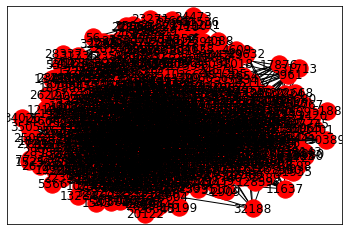

In [72]:

main_nx = read_graph_from_csv()    
main_nx = remove_nodes_with_low_degree(main_nx, n=1000)
print('')
# plot initial network of github users 
main_nx = draw_network(main_nx, color='red')


#### Lets prune this by running max weighted spanning tree algo

Name: 
Type: Graph
Number of nodes: 1000
Number of edges: 999
Average degree:   1.9980


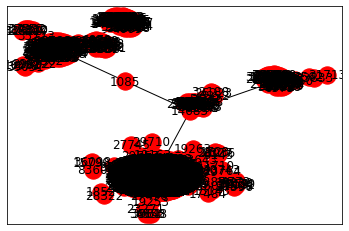

In [73]:
edge_list =  max_spanning_tree(main_nx, algorithm="kruskal")

prune_nx = draw_network(G, edge_list=edge_list, color='red')


In [74]:
communities, result_dicts = compute_metrics(prune_nx)
prune_nx = set_attributes(prune_nx, **result_dicts)
top_metrics = top_betweeness_nodes_with_attributes(prune_nx, top_n=20)
top_metrics.head()

shortest = shortest_path(prune_nx, source_id=1085, target_id=19263)
community_count = plot_community_class_count(communities)

,id,betweeness,Degree,Modularity
0,27803,0.924851,697,0
1,14683,0.433062,28,4
2,29982,0.337504,102,1
3,1085,0.307101,2,4
4,31890,0.107131,56,2


Name: 
Type: Graph
Number of nodes: 53
Number of edges: 52
Average degree:   1.9623


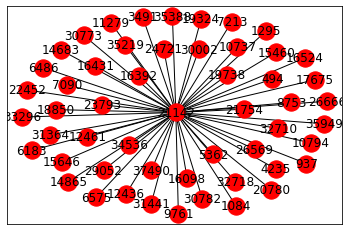

In [98]:
# this returns the entire graph as only one component in this graph 
#components, largest_component = connected_components(prune_nx)
#subgraph = plot_subgraph(prune_nx, largest_component)
# ego graph

ego_nx = plot_ego_network(prune_nx, 21142, radius = 1)

Generating for node: Wet_Grass: 100%|██████████| 4/4 [00:00<00:00, 127.52it/s]

[bnlearn] >Checking CPDs..
[bnlearn] >Check for DAG structure. Correct: True
[bnlearn] >Forward sampling for 1000 samples..
[bnlearn] >Plot based on BayesianModel


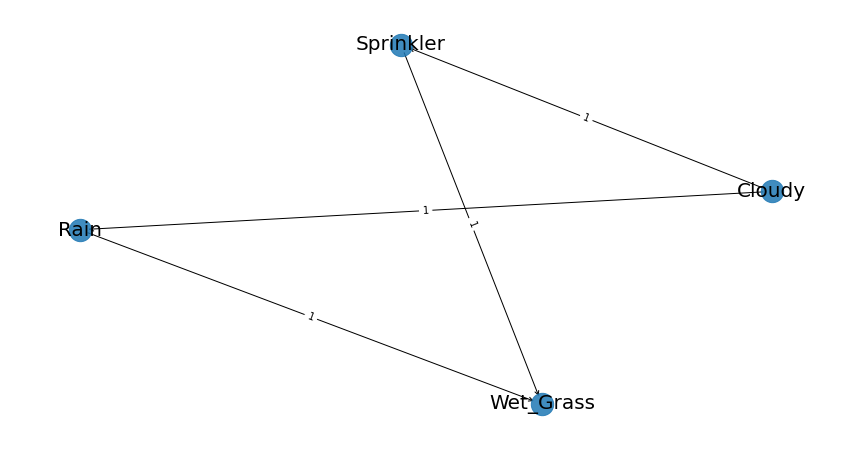

{'pos': {'Cloudy': array([0.84125178, 0.13964912]),
  'Sprinkler': array([-0.12390643,  0.92615471]),
  'Rain': array([-0.96037167, -0.06580383]),
  'Wet_Grass': array([ 0.24302633, -1.        ])},
 'G': <networkx.classes.digraph.DiGraph at 0x7fd0e28a40d0>}

In [2]:
# The following models can be loaded:
loadfile = 'sprinkler'
#loadfile = 'alarm'
#loadfile = 'andes'
#loadfile = 'asia'
#loadfile = 'sachs'

DAG = bnlearn.import_DAG(loadfile, CPD=True)
df = bnlearn.sampling(DAG, n=1000)
df.head()
bnlearn.plot(DAG)

In [9]:
#df_small = df.iloc[:, 0:20]
df_small = df.copy()
df_small.head()

,Cloudy,Rain,Sprinkler,Wet_Grass
0,1,0,0,0
1,1,1,0,1
2,1,1,0,1
3,1,0,0,0
4,0,0,0,0


In [47]:
#model = BayesianNetwork.from_samples(df_small, algorithm='exact')

In [51]:
# Funtion to evaluate the learned model structures.
def get_f1_score(estimated_model, true_model):
    nodes = estimated_model.nodes()
    est_adj = nx.to_numpy_matrix(estimated_model.to_undirected(), nodelist=nodes, weight=None)
    true_adj = nx.to_numpy_matrix(true_model.to_undirected(), nodelist=nodes, weight=None)
    
    f1 = f1_score(np.ravel(true_adj), np.ravel(est_adj))
    print("F1-score for the model skeleton: ", f1)
    
def plot_network(model):
    nx.draw(model, with_labels=True)
    plt.show()


Working for n conditional variables: 3:  75%|███████▌  | 3/4 [00:00<00:00, 18.42it/s]


In [19]:

scoring_method = K2Score(data=df_small)
est = HillClimbSearch(data=df_small)
estimated_model = est.estimate(scoring_method=scoring_method, max_indegree=4, max_iter=int(1e4))

  0%|          | 7/10000 [00:00<03:05, 53.86it/s]


In [23]:
estimated_model.edges()

OutEdgeView([('Rain', 'Cloudy'), ('Sprinkler', 'Cloudy'), ('Sprinkler', 'Wet_Grass'), ('Sprinkler', 'Rain'), ('Wet_Grass', 'Rain'), ('Wet_Grass', 'Cloudy')])

In [26]:
est.estimate(max_indegree=2).edges()

  0%|          | 5/1000000 [00:00<5:39:25, 49.10it/s]


OutEdgeView([('Cloudy', 'Rain'), ('Sprinkler', 'Cloudy'), ('Sprinkler', 'Wet_Grass'), ('Wet_Grass', 'Rain'), ('Wet_Grass', 'Cloudy')])

In [54]:
model = BayesianModel([('Cloudy', 'Rain'), ('Sprinkler', 'Cloudy'), ('Sprinkler', 'Wet_Grass'), ('Wet_Grass', 'Rain'), ('Wet_Grass', 'Cloudy')])

print(MaximumLikelihoodEstimator(model, df_small).estimate_cpd('Cloudy'))

+-----------+---------------------+---------------------+----------------------+---------------------+
| Sprinkler | Sprinkler(0)        | Sprinkler(0)        | Sprinkler(1)         | Sprinkler(1)        |
+-----------+---------------------+---------------------+----------------------+---------------------+
| Wet_Grass | Wet_Grass(0)        | Wet_Grass(1)        | Wet_Grass(0)         | Wet_Grass(1)        |
+-----------+---------------------+---------------------+----------------------+---------------------+
| Cloudy(0) | 0.6208955223880597  | 0.13672922252010725 | 0.9523809523809523   | 0.8376383763837638  |
+-----------+---------------------+---------------------+----------------------+---------------------+
| Cloudy(1) | 0.37910447761194027 | 0.8632707774798928  | 0.047619047619047616 | 0.16236162361623616 |
+-----------+---------------------+---------------------+----------------------+---------------------+


In [42]:

scoring_method = BicScore(data=df_small)
scoring_method.score(estimated_model)

-1952.183093738699

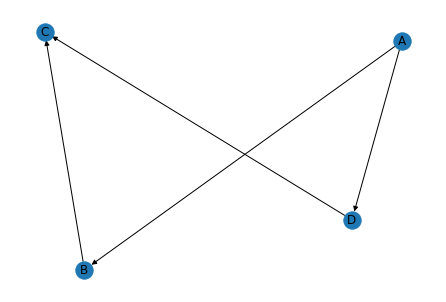

In [53]:
plot_network(model)

In [58]:
estimator = BayesianEstimator(model, df_small)
print(estimator.estimate_cpd('Cloudy', prior_type="K2"))

+-----------+--------------------+---------------------+---------------------+---------------------+
| Sprinkler | Sprinkler(0)       | Sprinkler(0)        | Sprinkler(1)        | Sprinkler(1)        |
+-----------+--------------------+---------------------+---------------------+---------------------+
| Wet_Grass | Wet_Grass(0)       | Wet_Grass(1)        | Wet_Grass(0)        | Wet_Grass(1)        |
+-----------+--------------------+---------------------+---------------------+---------------------+
| Cloudy(0) | 0.6201780415430267 | 0.13866666666666666 | 0.9130434782608695  | 0.8351648351648352  |
+-----------+--------------------+---------------------+---------------------+---------------------+
| Cloudy(1) | 0.3798219584569733 | 0.8613333333333333  | 0.08695652173913043 | 0.16483516483516483 |
+-----------+--------------------+---------------------+---------------------+---------------------+


Building tree: 100%|██████████| 6/6.0 [00:00<00:00, 2556.46it/s]


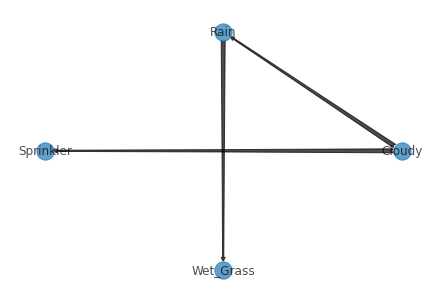

In [69]:
est = TreeSearch(df_small, root_node='Cloudy')
model = est.estimate(estimator_type='chow-liu')
nx.draw_circular(model, with_labels=True, arrowsize=10, arrowstyle='fancy',
                 alpha=0.7)
plt.show()

In [97]:
import pandas as pd
import numpy as np


chi_square(X='Cloudy', Y='Wet_Grass', Z=['Rain'], data=df_small,significance_level=0.05, boolean=False)


(43.14718340394357, 2, 4.2727565929823186e-10)